# Imports

In [1]:
from os.path import join as pjoin
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm, trange
tqdm.pandas()
import pickle
from os.path import join as pjoin
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score as AUPRC
from sklearn.metrics import roc_auc_score as ROC

dataloader_path_template = "pca_normal_data/{benchmark}_{model}_{attack}_{type}"
dir_template = "dataset/original/{benchmark}/{model}/{attack}"

# I. PCA-Normal Experiment

In [2]:
from sklearn.decomposition import KernelPCA as kPCA
from scipy.stats import multivariate_normal
from generate_adversarial_embeddings import EmbeddingDataset

In [3]:
with open("pca_normal_data/imdb_bert_bae_source.pkl", "rb") as f:
    dl = pickle.load(f)
    data_source = dl.data
data_source.shape

torch.Size([10000, 768])

Reduce dimension with Kernel PCA

In [4]:
transformer = kPCA(n_components=2, kernel='cosine')
pca_source = transformer.fit_transform(data_source)
pca_source.shape

(10000, 2)

Find nearest normal distribution w.r.t to the principal components of the embeddings

In [5]:
mean = np.mean(pca_source, axis=0)
covariance = np.cov(pca_source, rowvar=False)
mvn = multivariate_normal(mean=mean, cov=covariance)

## Evaluation on every perturbated examples

100%|██████████| 10000/10000 [00:00<00:00, 85822.05it/s]


<Axes: xlabel='source embeddings', ylabel='perturbated embeddings'>

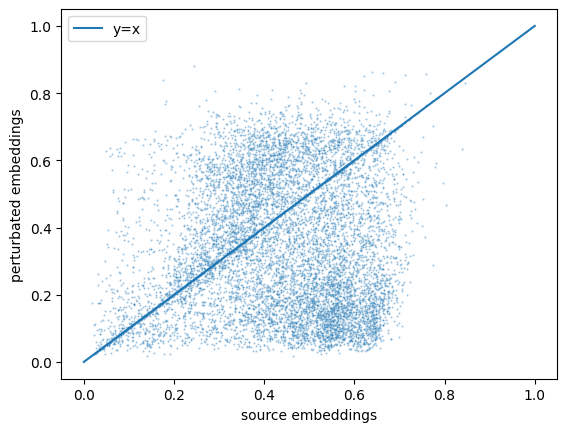

In [6]:
with open("pca_normal_data/imdb_bert_bae_adv.pkl", "rb") as f:
    dl = pickle.load(f)
    data_adv = dl.data

pca_adv = transformer.transform(data_adv)

source_pdfs = np.array([mvn.pdf(e) for e in tqdm(pca_source)])
perturbated_pdfs = np.array([mvn.pdf(e) for e in tqdm(pca_adv)])

sns.scatterplot(pd.DataFrame({'source embeddings': source_pdfs, 'perturbated embeddings': perturbated_pdfs}), 
                x='source embeddings', y='perturbated embeddings', s=2, alpha=0.45)
sns.lineplot(pd.DataFrame({'y=x': [0, 1]}))

<Axes: ylabel='Count'>

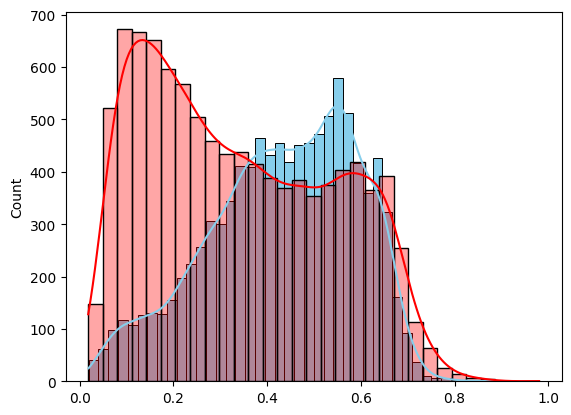

In [7]:
sns.histplot(data=source_pdfs, color="skyblue", label="Vanilla texts", kde=True, alpha=1)
sns.histplot(data=perturbated_pdfs, color="red", label="Adversarial texts", kde=True, alpha=0.35)

## Evaluation only among successful adversarial examples

In [8]:
#Get index of successful, truly adversarial examples

df = pd.read_csv(pjoin(
    dir_template.format(**dict(
        benchmark='imdb',
        model='bert',
        attack='bae'
    )),
    "bert-base-uncased-imdb_bae.csv"
))

bool_index = torch.tensor((df.result_type == 'Successful').to_numpy())

100%|██████████| 5989/5989 [00:00<00:00, 48364.29it/s]


<Axes: xlabel='source embeddings', ylabel='corresponding adversarial embeddings'>

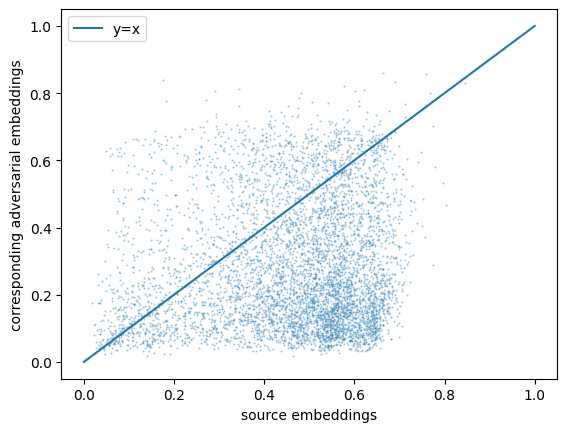

In [9]:
data_source = data_source[bool_index]
data_adv = data_adv[bool_index]

pca_source = transformer.transform(data_source)
pca_adv = transformer.transform(data_adv)

source_pdfs = np.array([mvn.pdf(e) for e in tqdm(pca_source)])
perturbated_pdfs = np.array([mvn.pdf(e) for e in tqdm(pca_adv)])

sns.scatterplot(pd.DataFrame({'source embeddings': source_pdfs, 'corresponding adversarial embeddings': perturbated_pdfs}), 
                x='source embeddings', y='corresponding adversarial embeddings', s=2, alpha=0.45)
sns.lineplot(pd.DataFrame({'y=x': [0, 1]}))

<Axes: ylabel='Count'>

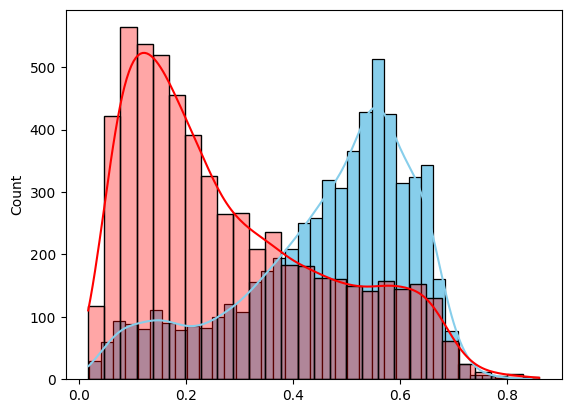

In [10]:
sns.histplot(data=source_pdfs, color="skyblue", label="Vanilla texts", kde=True, alpha=1)
sns.histplot(data=perturbated_pdfs, color="red", label="Adversarial texts", kde=True, alpha=0.35)

## Score for a predictor on clean texts vs successful adversarial examples (unbalanced classification)

First, we build the labeled database of clean, original texts (1) and successful adversarial texts (0)

In [15]:
with open("pca_normal_data/imdb_bert_bae_source.pkl", "rb") as f:
    dl = pickle.load(f)
    data_source = dl.data
pca_source = transformer.transform(data_source)
source_pdfs = np.array([mvn.pdf(e) for e in tqdm(pca_source)])

source_pdfs.shape, perturbated_pdfs.shape

100%|██████████| 10000/10000 [00:00<00:00, 45070.43it/s]


((10000,), (5989,))

Given a threshold $t \in [0, 1]$, we have define a predictor $f_t : x\rightarrow pdf(pca(x))$ to detect whether $x$ is an attack (0) or not (1)

In the unbalanced context, we should pay more attention to the AUPRC than the ROC score

In [46]:
y_pred = np.array(list(source_pdfs) + list(perturbated_pdfs))
y_true = np.zeros_like(y_pred)
y_true[:len(source_pdfs)] = 1

print("AUPRC:", AUPRC(y_true, y_pred), "AUROC", ROC(y_true, y_pred))

AUPRC: 0.7612281084623007 ROC 0.7366447069627651


## Score for a predictor on clean/adversarial pairs (balanced classification)

In [49]:
source_pdfs = source_pdfs[bool_index]

source_pdfs.shape, perturbated_pdfs.shape

((5989,), (5989,))

In this case, we should pay more attention to the ROC

In [52]:
y_pred = np.array(list(source_pdfs) + list(perturbated_pdfs))
y_true = np.zeros_like(y_pred)
y_true[:len(source_pdfs)] = 1

print("AUPRC:", AUPRC(y_true, y_pred), "AUROC", ROC(y_true, y_pred))

AUPRC: 0.6900983662834166 AUROC 0.7603278828015552


# II. Softmax-based experiment

In [15]:
from transformers import pipeline

In [16]:
df = pd.read_csv(pjoin(
    dir_template.format(**dict(
        benchmark='imdb',
        model='bert',
        attack='bae'
    )),
    "bert-base-uncased-imdb_bae.csv"
))

clean_attack = lambda s: s.replace('[', '').replace(']', '')
df["original_text"] = df.original_text.apply(clean_attack)
df["perturbed_text"] = df.perturbed_text.apply(clean_attack)
df = df[['original_text', 'perturbed_text', 'original_score', 'perturbed_score', 'result_type']]

In [17]:
ref = "textattack/bert-base-uncased-imdb"
nlp = pipeline("text-classification", model=ref, max_length=512)

A motivation: the softmax activation function encourages the network to output cleaving probabilities, even if the input is noisy

In [115]:
text = "s"
result = nlp(text)
result

[{'label': 'LABEL_0', 'score': 0.749290406703949}]

First visualisation : max probability predicted for normal vs adversarial examples

In [19]:
source_probas = df.original_text.progress_apply(lambda x: nlp(x)[0]['score'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
adv_probas = df[df.result_type=="Successful"].perturbed_text.progress_apply(lambda x: nlp(x)[0]['score'])

  0%|          | 0/5989 [00:00<?, ?it/s]

In [38]:
with open("proba_cols/source.pkl", "wb") as f:
    pickle.dump(source_probas, f)

In [40]:
source_probas.mean(), source_probas.min()

(0.9884894343793392, 0.5014958381652832)

<Axes: xlabel='perturbed_text', ylabel='Count'>

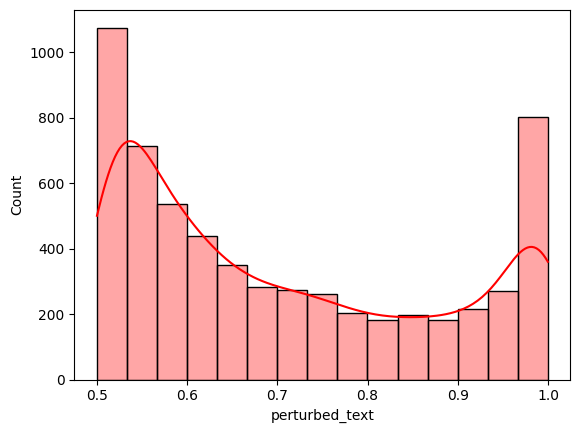

In [30]:
sns.histplot(data=adv_probas, color="red", label="Adversarial texts", kde=True, alpha=0.35)

In [46]:
source_probas.quantile(0.05)

0.9526682913303376

In [85]:
def predictor(threshold):
    return lambda score : 0 if score > threshold else 1

source, perturbated = source_probas.to_numpy(), adv_probas.to_numpy()
y_true = np.concatenate([np.zeros_like(source_probas), np.ones_like(adv_probas)])
y_true.shape

(15989,)

In [86]:
threshold_list = [0.01*i for i in range(51, 100)]

auprc_list, auroc_list = [], []

for threshold in tqdm(threshold_list):
    model = predictor(threshold)
    y_pred = [model(soft_proba) for soft_proba in np.concatenate([source_probas, adv_probas])]
    
    auprc_list.append(AUPRC(y_true, y_pred))
    auroc_list.append(ROC(y_true, y_pred))

  0%|          | 0/49 [00:00<?, ?it/s]

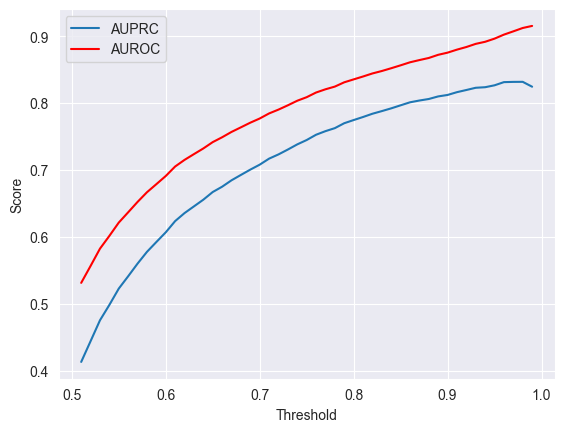

In [88]:
sns.set_style("darkgrid")

plt.plot(threshold_list, auprc_list, label='AUPRC')
plt.plot(threshold_list, auroc_list, 'r', label='AUROC')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()

plt.show()

# III. Auxiliary decoder

In [4]:
import torch
nn = torch.nn
from utils.utils_auxiliary import IMDB, collator, ClassifierWithAuxiliaryAutoencoder

#define model
autoencoder_dim = 3
abnormality_dim = 128
model = ClassifierWithAuxiliaryAutoencoder(autoencoder_dim, abnormality_dim)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Phase 1 : Joined training of autoencoder and sentiment analysis

In [5]:
# Get only normal data
data_loader = DataLoader(
        dataset=IMDB(mode='normal_only'),
        batch_size=16,
        shuffle=True,
        collate_fn=collator,
        pin_memory=True,
        drop_last=True,
    )

# Freeze abnormality module
for param in model.abnormality_module.parameters():
    param.requires_grad = False

# Train jointly on reconstruction loss and sentiment analysis loss
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in trange(4):
    mse_losses, bce_losses = [], []
    for batch in data_loader:
        tokens, labels = batch['tokens'], batch['labels'].reshape(-1, 1)

        optimizer.zero_grad()
        res = model(tokens)
        mse = mse_loss(res["reconstructed_pool"], res["pool"])
        bce = bce_loss(res["sentiment"], labels)
        loss = mse + bce
        loss.backward()
        optimizer.step()

        mse_losses.append(mse.detach().numpy())
        bce_losses.append(bce.detach().numpy())

    mse_losses = np.round(np.array(mse_losses).mean(), 3)
    bce_losses = np.round(np.array(bce_losses).mean(), 3)

    print(f"Epoch {1+epoch}: mse {mse_losses} - bce {bce_losses}")

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: mse 0.017999999225139618 - bce 0.4390000104904175
Epoch 2: mse 0.0010000000474974513 - bce 0.15000000596046448
Epoch 3: mse 0.0010000000474974513 - bce 0.061000000685453415
Epoch 4: mse 0.0 - bce 0.03799999877810478


## Phase 2 : Training only on abnormality module

In [24]:
# from torch.utils.data import WeightedRandomSampler

# targets = np.array(list(data_loader.dataset.label))
# labels_uniques, counts = np.unique(targets, return_counts=True)
# class_weights = [sum(counts)/c for c in counts]
# weights = [class_weights[x] for x in targets]
# sampler = WeightedRandomSampler(weights, len(targets))

In [25]:
# model.load_state_dict(torch.load("saved_models/auxiliary.pt"))

In [7]:
# Get both normal and adversarial data
data_loader = DataLoader(
        dataset=IMDB(mode='adv_mix'),
        batch_size=128,
        shuffle=True,
        # sampler=sampler,
        collate_fn=collator,
        pin_memory=True,
        drop_last=True,
    )

# Freeze everything but the abnormality module
for param in model.parameters():
    param.requires_grad = False
for param in model.abnormality_module.parameters():
    param.requires_grad = True

# Train on classifying abnormality
bce_loss = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for epoch in trange(10):
    bce_losses = []
    auprc, auroc = [], []
    for batch in data_loader:
        tokens, labels = batch['tokens'], batch['labels'].reshape(-1, 1)

        optimizer.zero_grad()
        res = model(tokens)
        bce = bce_loss(res["is_adv"], labels)
        loss = bce
        loss.backward()
        optimizer.step()

        bce_losses.append(bce.detach().numpy())
        auprc.append(AUPRC(labels.detach().numpy(), res["is_adv"].detach().numpy()))
        auroc.append(ROC(labels.detach().numpy(), res["is_adv"].detach().numpy()))

    bce_losses = np.array(bce_losses).mean()
    auprc = np.array(auprc).mean()
    auroc = np.array(auroc).mean()

    print(f"Epoch {1+epoch}: bce {np.round(bce_losses, 3)} - auprc {np.round(auprc, 3)} - auroc {np.round(auroc, 3)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: bce 0.6520000100135803 - auprc 0.536 - auroc 0.628
Epoch 2: bce 0.6370000243186951 - auprc 0.539 - auroc 0.652
Epoch 3: bce 0.6320000290870667 - auprc 0.55 - auroc 0.657
Epoch 4: bce 0.6269999742507935 - auprc 0.554 - auroc 0.659
Epoch 5: bce 0.6269999742507935 - auprc 0.56 - auroc 0.661
Epoch 6: bce 0.6269999742507935 - auprc 0.56 - auroc 0.662
Epoch 7: bce 0.6309999823570251 - auprc 0.562 - auroc 0.663
Epoch 8: bce 0.6259999871253967 - auprc 0.561 - auroc 0.661
Epoch 9: bce 0.621999979019165 - auprc 0.562 - auroc 0.662
Epoch 10: bce 0.6230000257492065 - auprc 0.564 - auroc 0.664


## Save inference model

In [5]:
torch.save(model.state_dict(), "saved_models/auxiliary.pt")